In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy.stats import norm,kstest,shapiro,t
import warnings
import seaborn as sns
import statistics
warnings.filterwarnings('ignore')
import yfinance as yf
from datetime import *



In [2]:
#extracting data
minTick_data = pd.read_csv("stock_data_mintick2.csv")
minTick_data.set_index('date',inplace=True)
minTick_data.index = pd.to_datetime(minTick_data.index)
minTick_data.head()

AAOI     AAPL     ABM  ACEV  ACEVU    ACIW    ACLS  \
date                                                                       
2020-02-27 09:30:00  9.895  70.8500  35.155   NaN    NaN  27.855  23.315   
2020-02-27 09:31:00  9.895  70.9025  35.140   NaN    NaN  26.620  23.200   
2020-02-27 09:32:00  9.720  70.7200  34.890   NaN    NaN  26.390  23.195   
2020-02-27 09:33:00  9.700  70.9513  34.890   NaN    NaN  26.650  22.980   
2020-02-27 09:34:00  9.715  70.6675  34.880   NaN    NaN  26.495  22.945   

                       ACMR  ACVA    ACY  ...  AWRE  AYX  AZPN  BAND  BASE  \
date                                      ...                                
2020-02-27 09:30:00  35.425   NaN  0.889  ...   NaN  NaN   NaN   NaN   NaN   
2020-02-27 09:31:00  35.615   NaN  0.889  ...   NaN  NaN   NaN   NaN   NaN   
2020-02-27 09:32:00  35.350   NaN  0.889  ...   NaN  NaN   NaN   NaN   NaN   
2020-02-27 09:33:00  35.500   NaN  0.889  ...   NaN  NaN   NaN   NaN   NaN   
2020-02-27 09:34:00  35.590   NaN  0.889  ...   NaN  NaN   NaN   NaN   NaN   

                     BBAI  BBSI  BCOV  BDR  BEAT  
date                                              
2020-02-27 09:30:00   NaN   NaN   NaN  NaN   NaN  
2020-02-27 09:31:00   NaN   NaN   NaN  NaN   NaN  
2020-02-27 09:32:00   NaN   NaN   NaN  NaN   NaN  
2020-02-27 09:33:00   NaN   NaN   NaN  NaN   NaN  
2020-02-27 09:34:00   NaN   NaN   NaN  NaN   NaN  

[5 rows x 79 columns]

In [31]:
# print the size of the whole date
m = minTick_data.shape[0]
n = minTick_data.shape[1]
minTick_data.shape


(196410, 79)

## Volatility Calculation
Calculate the rolling volatility of underlying asset prices %return.

### Q1.算历史波动率的时候应该取30min 60min 120min这个长度的来算波动率吗？
### Q2.算历史波动率的时候直接使用价格来算吗，还是使用收益率来算?

In [82]:
# calculate the hourly volatility by setting the period window = 60
period = 60
returns = minTick_data.pct_change()
volatility = returns.rolling(window=period).std()
corr_matrix = volatility.corr()
corr_matrix = corr_matrix.unstack()
print("The descending corr pair list below:")
print(corr_matrix.sort_values(ascending = False,kind="quicksort")[n:n+40])

The descending corr pair list below:
AVGO  ADI     0.906454
ADI   AVGO    0.906454
AVGO  ANSS    0.859849
ANSS  AVGO    0.859849
ADI   ANSS    0.858197
ANSS  ADI     0.858197
ADBE  ANSS    0.857824
ANSS  ADBE    0.857824
      ADSK    0.856784
ADSK  ANSS    0.856784
AVT   ACIW    0.848393
ACIW  AVT     0.848393
ADBE  ADSK    0.846194
ADSK  ADBE    0.846194
      ADI     0.845542
ADI   ADSK    0.845542
AVT   ADI     0.845086
ADI   AVT     0.845086
      ADBE    0.844655
ADBE  ADI     0.844655
ASML  ADI     0.843030
ADI   ASML    0.843030
AVGO  AVT     0.842266
AVT   AVGO    0.842266
APP   AMPL    0.840536
AMPL  APP     0.840536
AAPL  ADBE    0.837899
ADBE  AAPL    0.837899
ASML  AVGO    0.833018
AVGO  ASML    0.833018
      ADBE    0.831599
ADBE  AVGO    0.831599
ADI   ARW     0.831434
ARW   ADI     0.831434
AMKR  ADI     0.828876
ADI   AMKR    0.828876
AVGO  ADSK    0.825301
ADSK  AVGO    0.825301
ADI   ACIW    0.824103
ACIW  ADI     0.824103
dtype: float64


<AxesSubplot:>

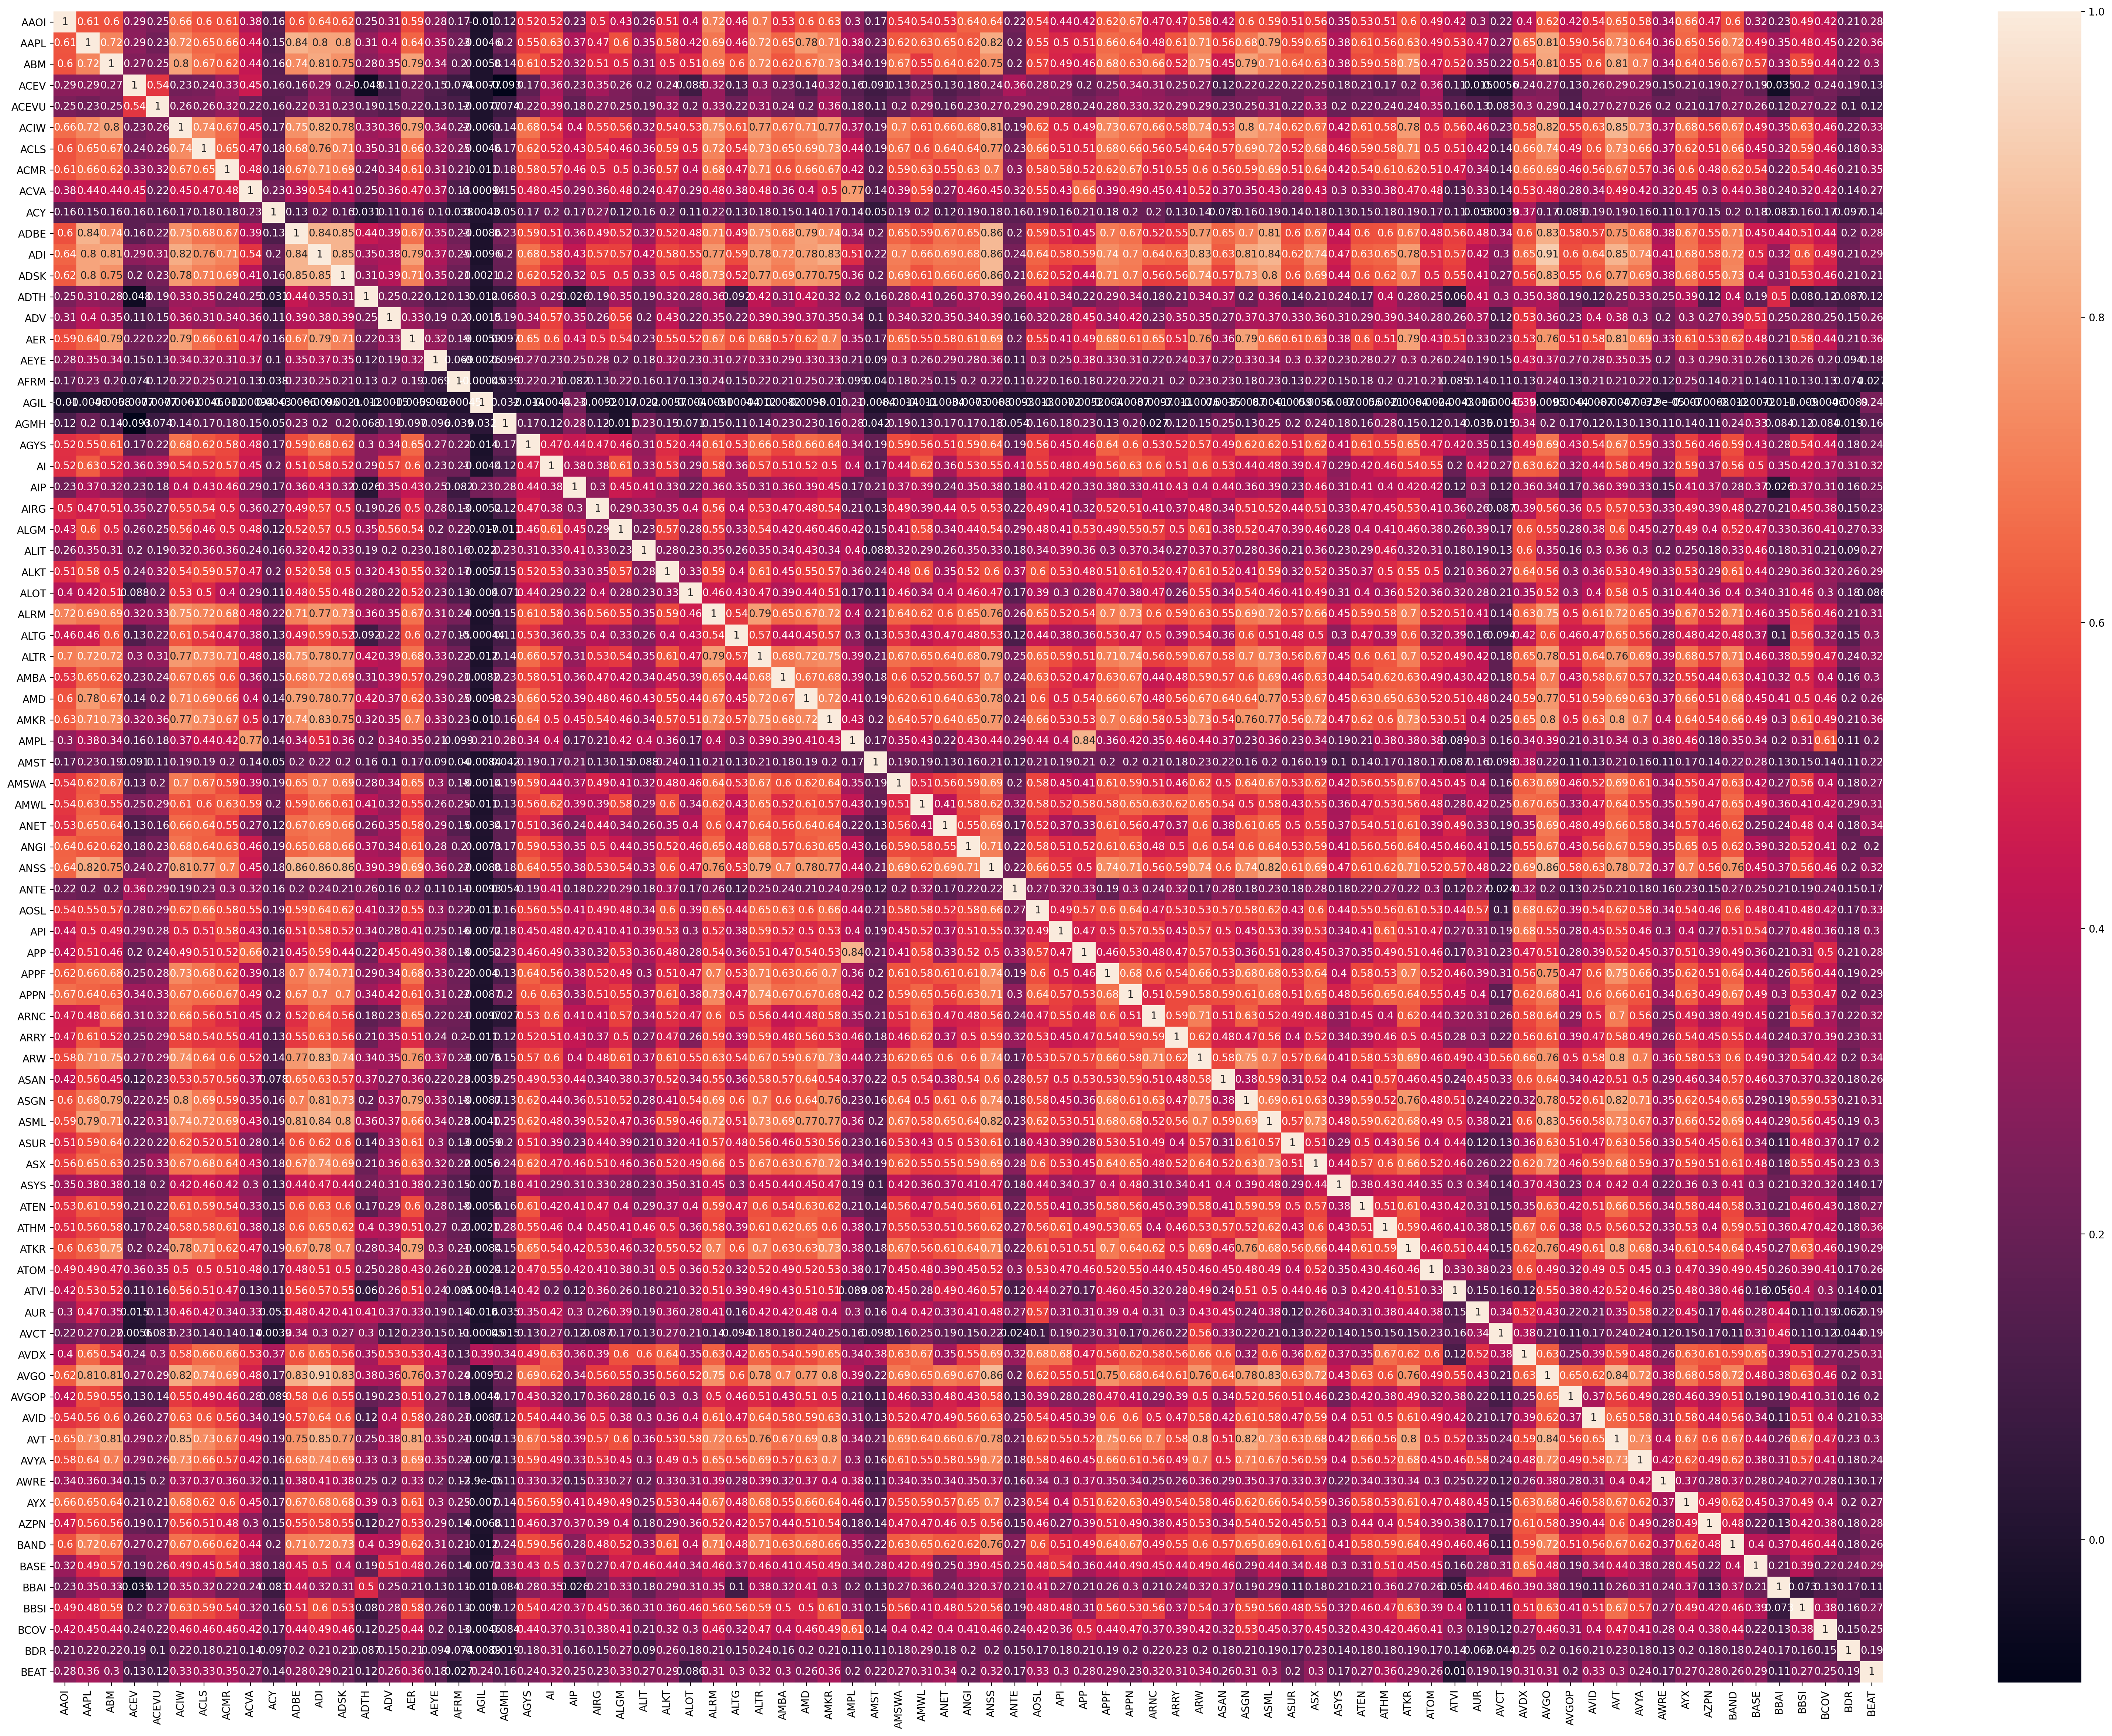

In [94]:
import seaborn as sn
from matplotlib.pyplot import figure
figure(figsize=(40, 30), dpi=200)
sn.heatmap(volatility.corr(), annot = True)

### Observe the volume of the option market to determine suitability for trading
|  options   | status  |
|  ----  | ----  |
| AVGO   | good to trade |
| ADI    | not high |
| ANSS   | good |
| ADBE    | good to trade |
| ADSK   | not high |
| AVT   | bad |
| ACIW   | bad |

We first use the ADBE and ANSS for volatility pair trading.

<Figure size 4000x3600 with 0 Axes>

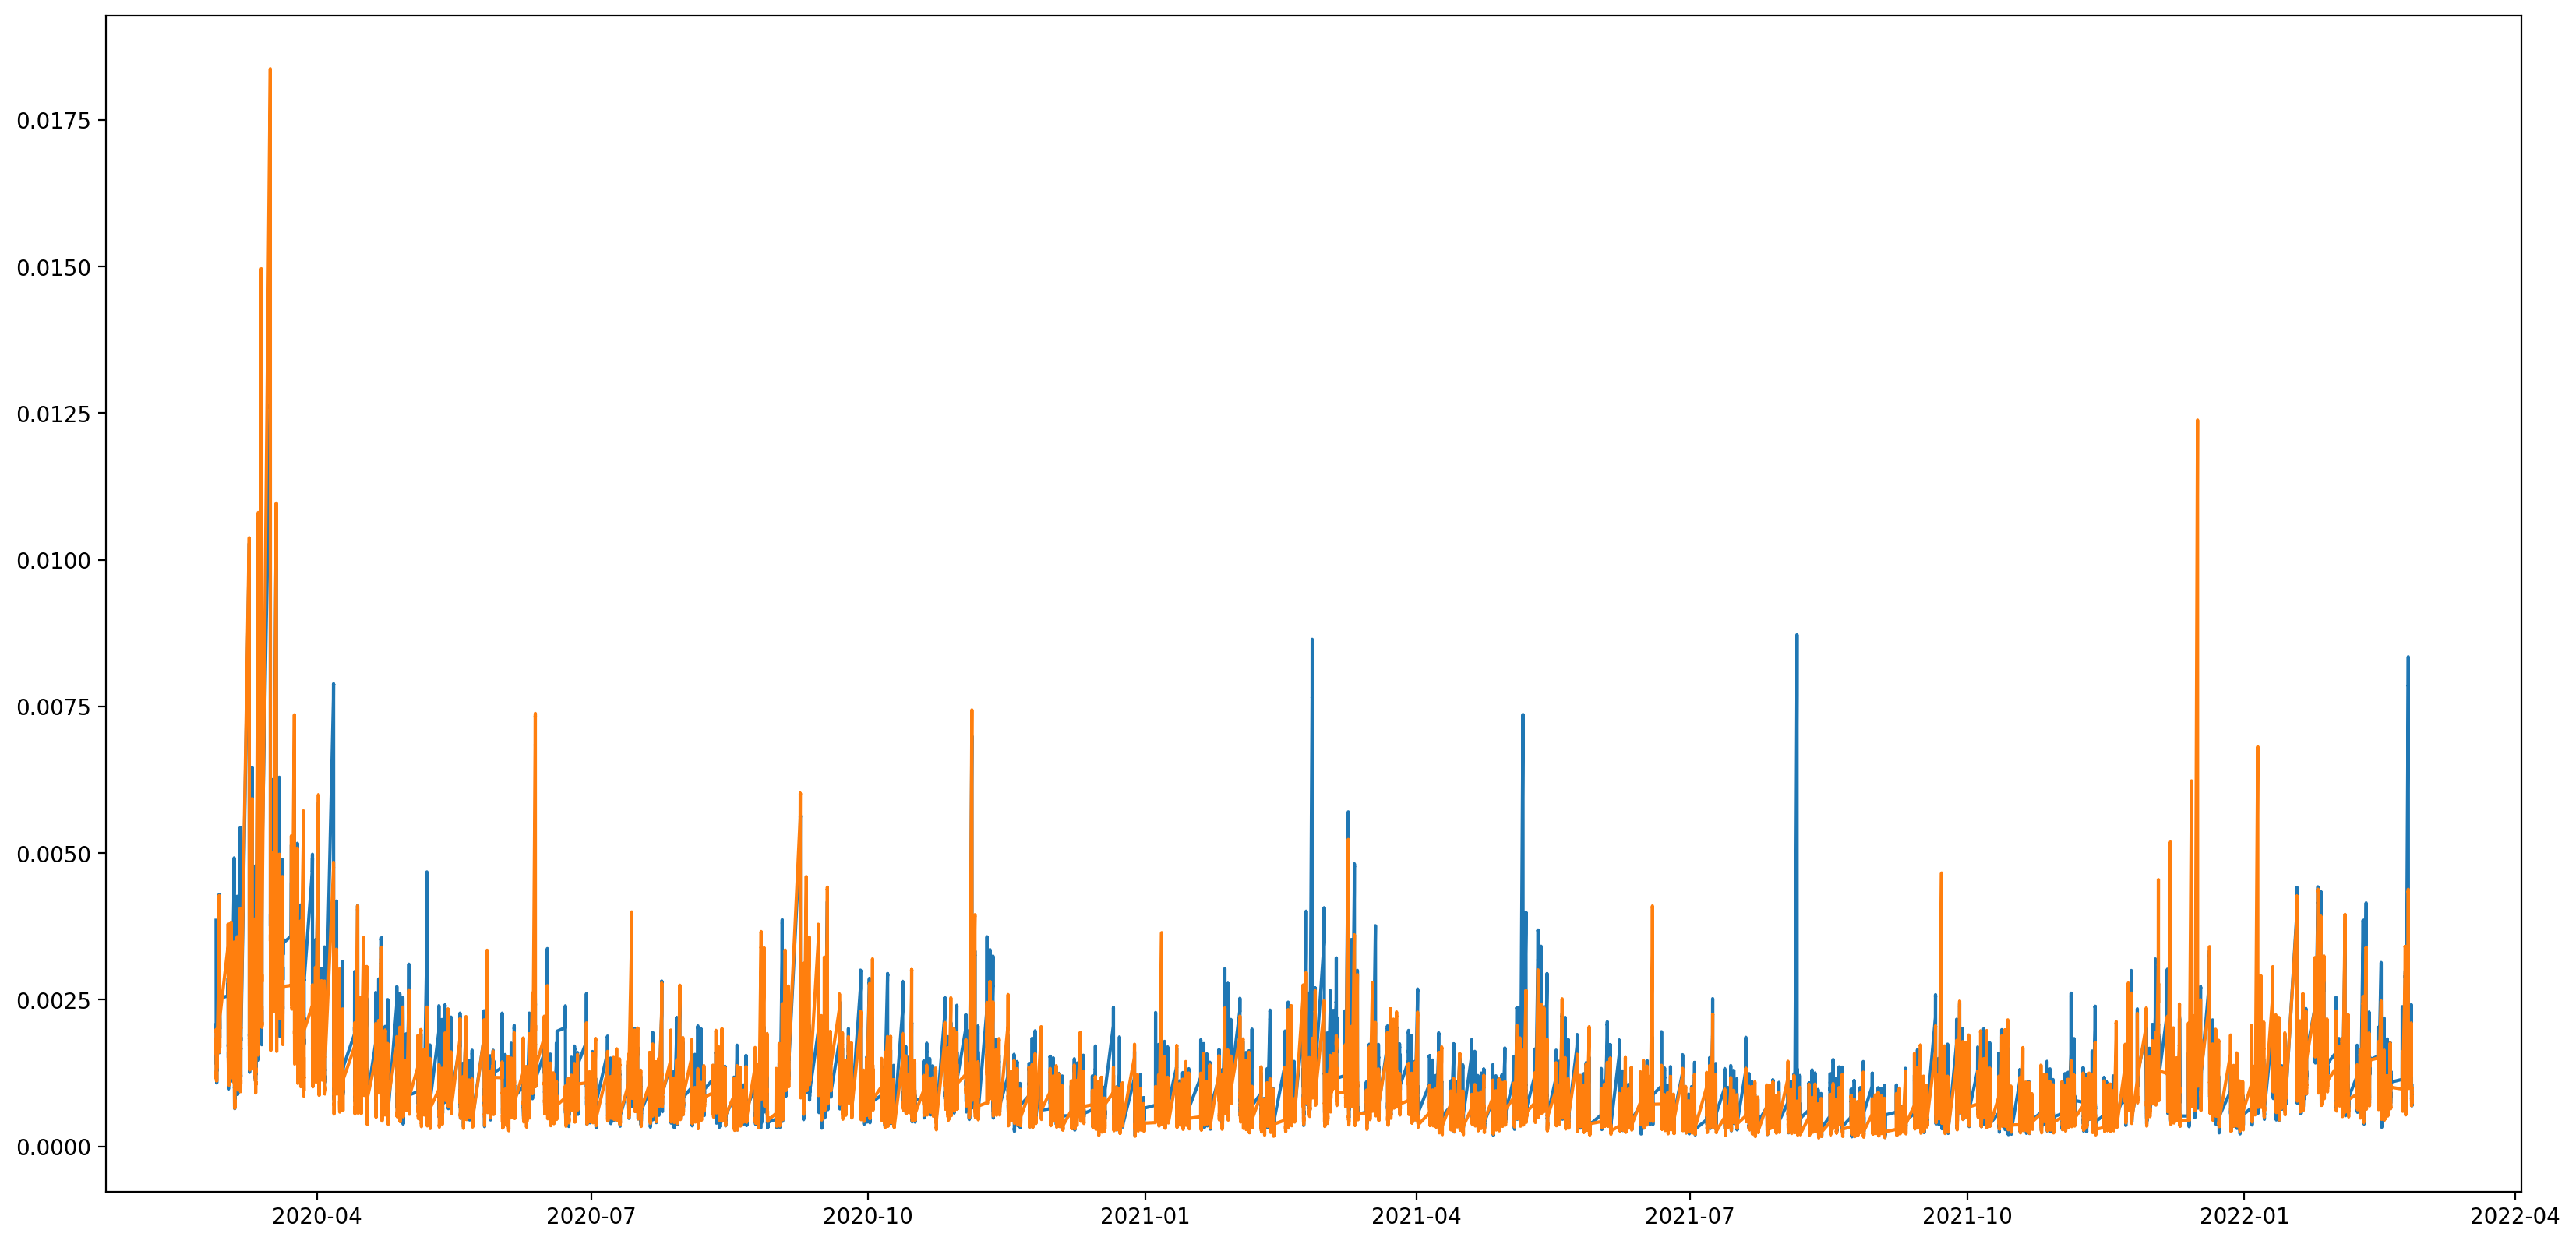

In [93]:
figure(figsize=(20, 18), dpi=200)

ANSS = volatility['ANSS'].dropna() # Adobe
ADBE = volatility['ADBE'].dropna() # ANSYS
figure(figsize=(20, 10), dpi=200)
plt.plot(ANSS, label = "ANSS")
plt.plot(ADBE, label = "ADBE")

Text(0.5, 1.0, 'Spread between ANSS and ADBE')

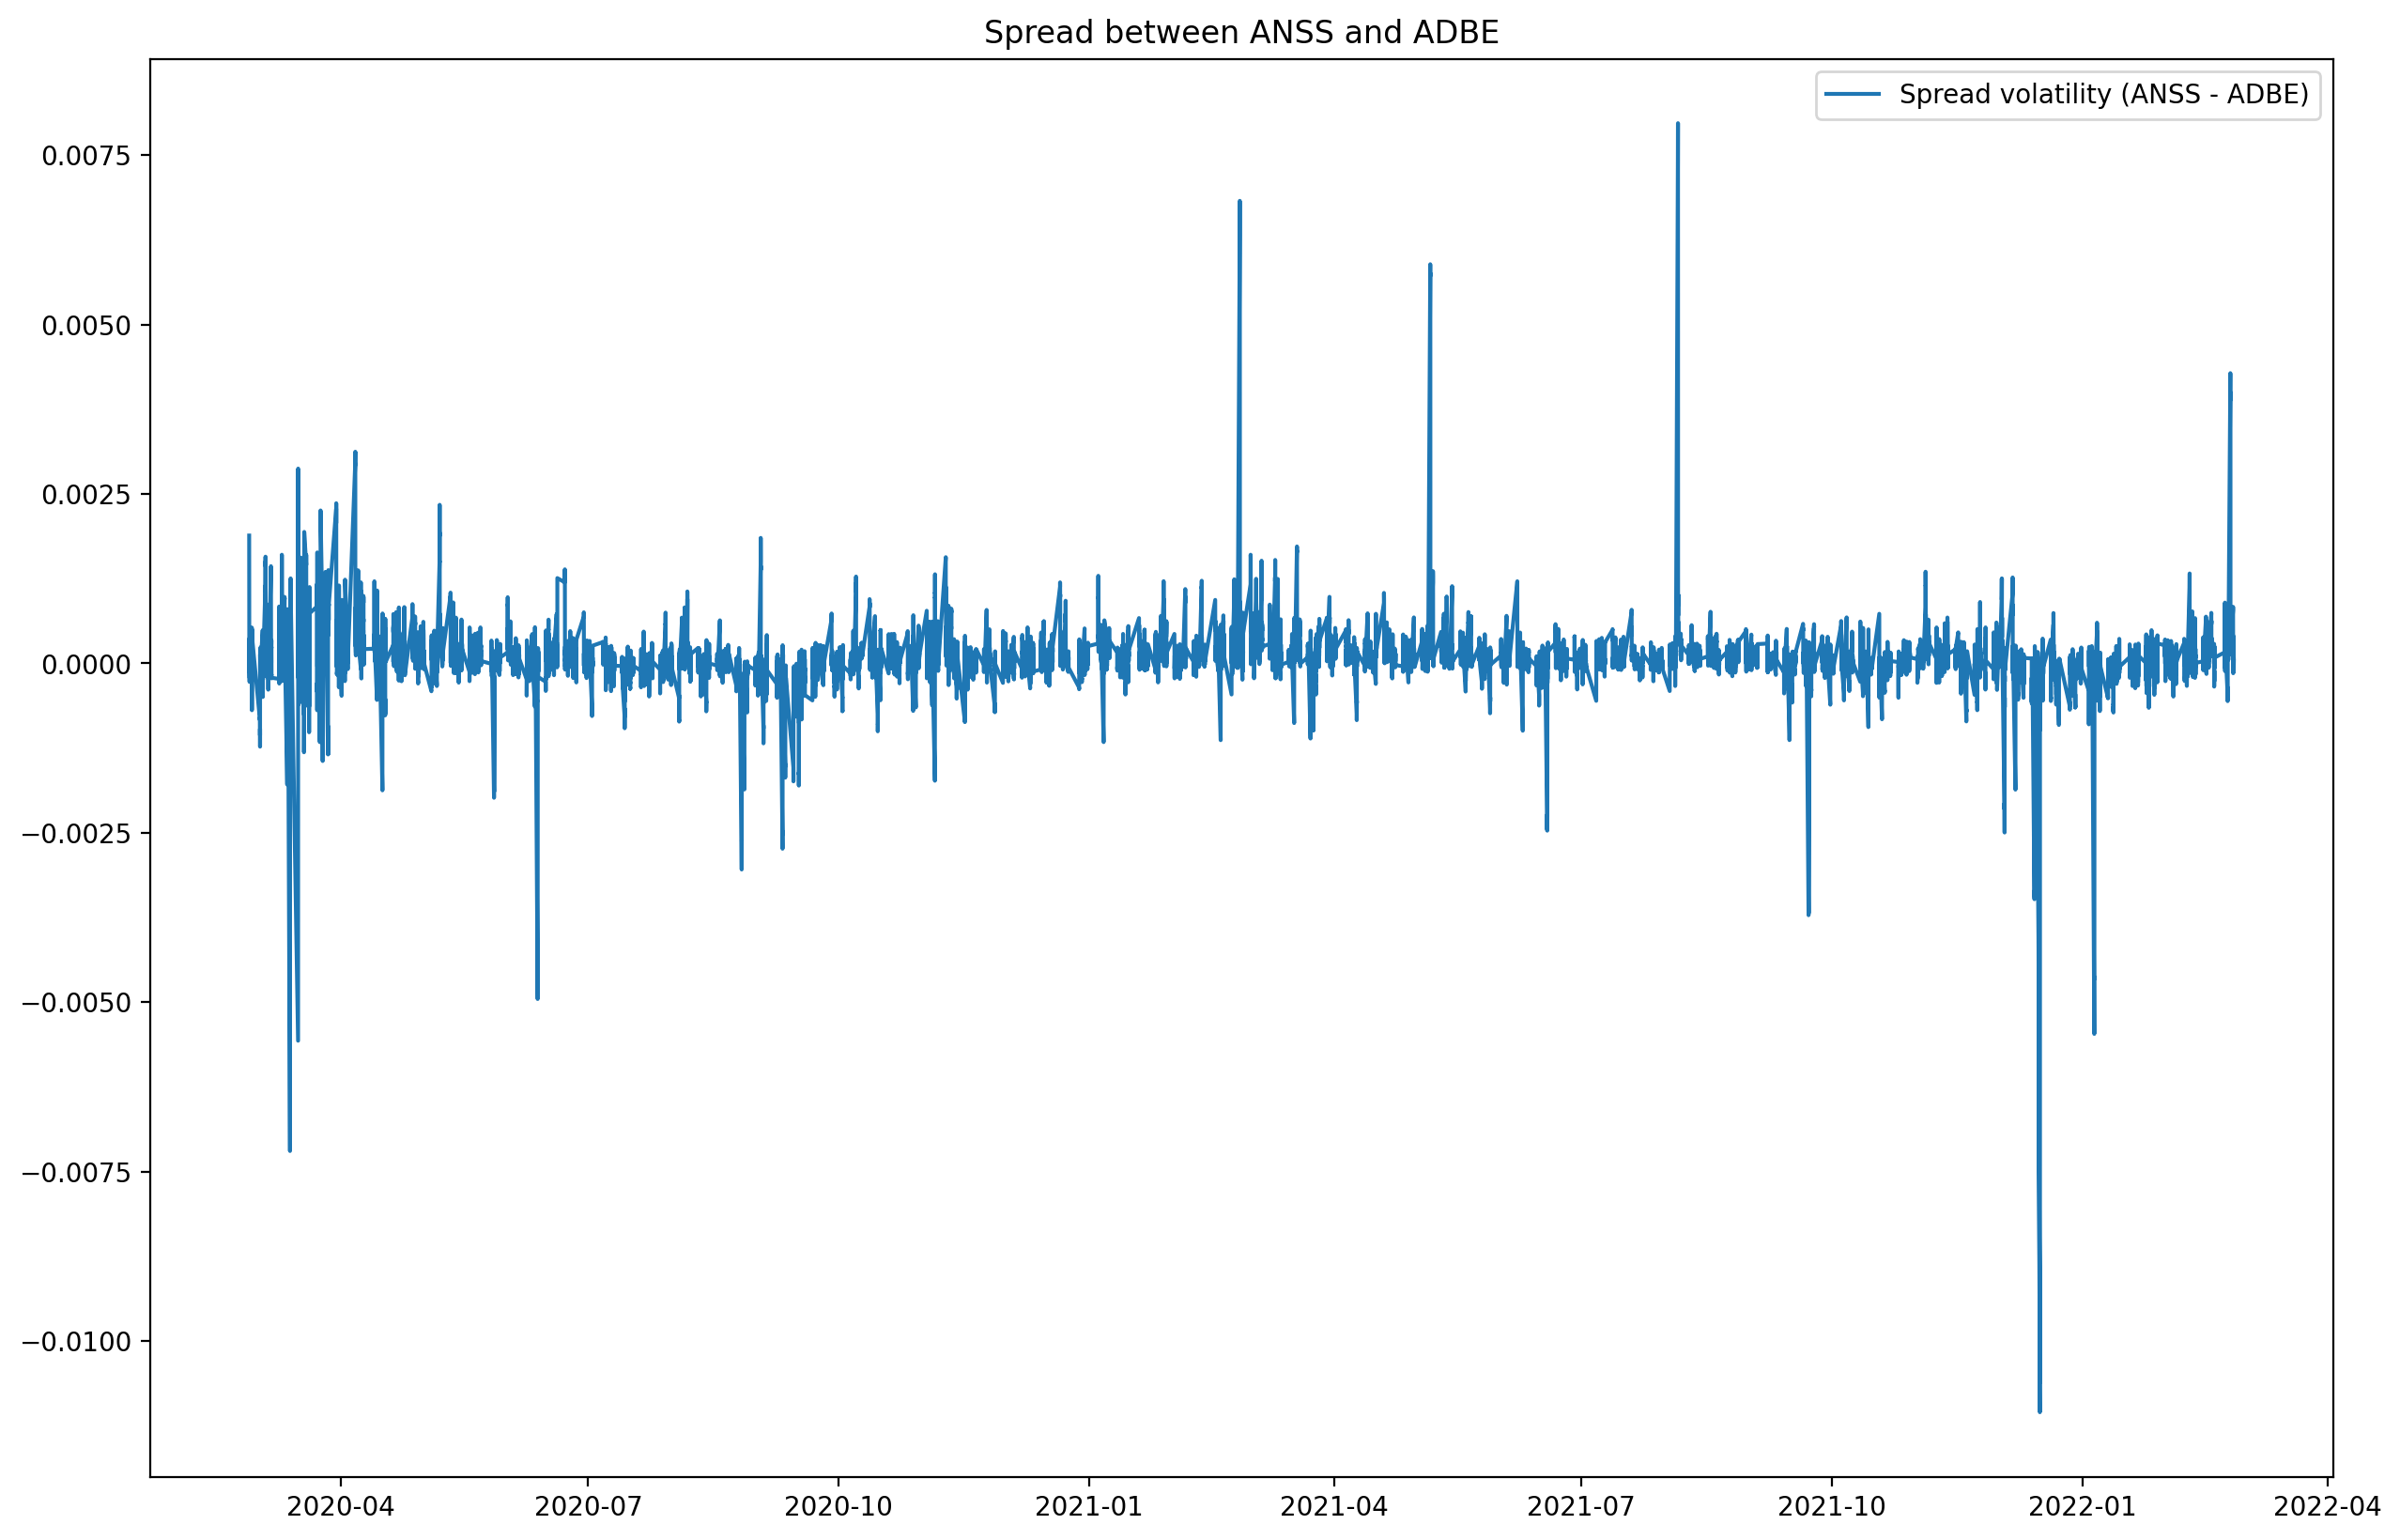

In [95]:
# find the spread of volatility
figure(figsize=(15, 10), dpi=200)
plt.plot(ANSS - ADBE, label = 'Spread volatility (ANSS - ADBE)')
plt.legend()
plt.title("Spread between ANSS and ADBE")

In [98]:
import statsmodels.tsa.stattools as ts 
result = ts.coint(ANSS, ADBE)
# Cointegration test: A technique used to find a potential correlation in a time series (long term)
# Determines if the spread between the two assets are constant over time.
# Null Hypothesis: Spread between series are non-stationary.
# Uses the augmented Engle-Granger two-step cointegration test.
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('We want the P val < 0.05 (meaning that cointegration exists)')
print('P value for the augmented Engle-Granger two-step cointegration test is', p_val)

We want the P val < 0.05 (meaning that cointegration exists)
P value for the augmented Engle-Granger two-step cointegration test is 0.0


In [100]:
from statsmodels.tsa.stattools import adfuller
# Compute the ADF test for ANSYS and Adobe
# With all time series, I want to have stationary data otherwise our data will be very hard to predict.
ANSS_ADF = adfuller(ANSS)
print('P value for the Augmented Dickey-Fuller Test is', ANSS_ADF[1])
ADBE_ADF = adfuller(ADBE)
print('P value for the Augmented Dickey-Fuller Test is', ADBE_ADF[1])
Spread_ADF = adfuller(ANSS - ADBE)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(ANSS / ADBE)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])
# Spread looks fine. If I'd want even better results, consider taking the difference (order 1) of ANSS and ADBE

# Results: can only claim stationary for the spread (since P value < 0.05). This suggests a constant mean over time.
# Therefore, the two series are cointegrated.

P value for the Augmented Dickey-Fuller Test is 0.0
P value for the Augmented Dickey-Fuller Test is 0.0
P value for the Augmented Dickey-Fuller Test is 0.0
P value for the Augmented Dickey-Fuller Test is 0.0


### Q3 波动率本身如果都是stationary data，那还有必要作差吗？

Text(0.5, 1.0, 'Vol Ratio between ANSS and ADBE')

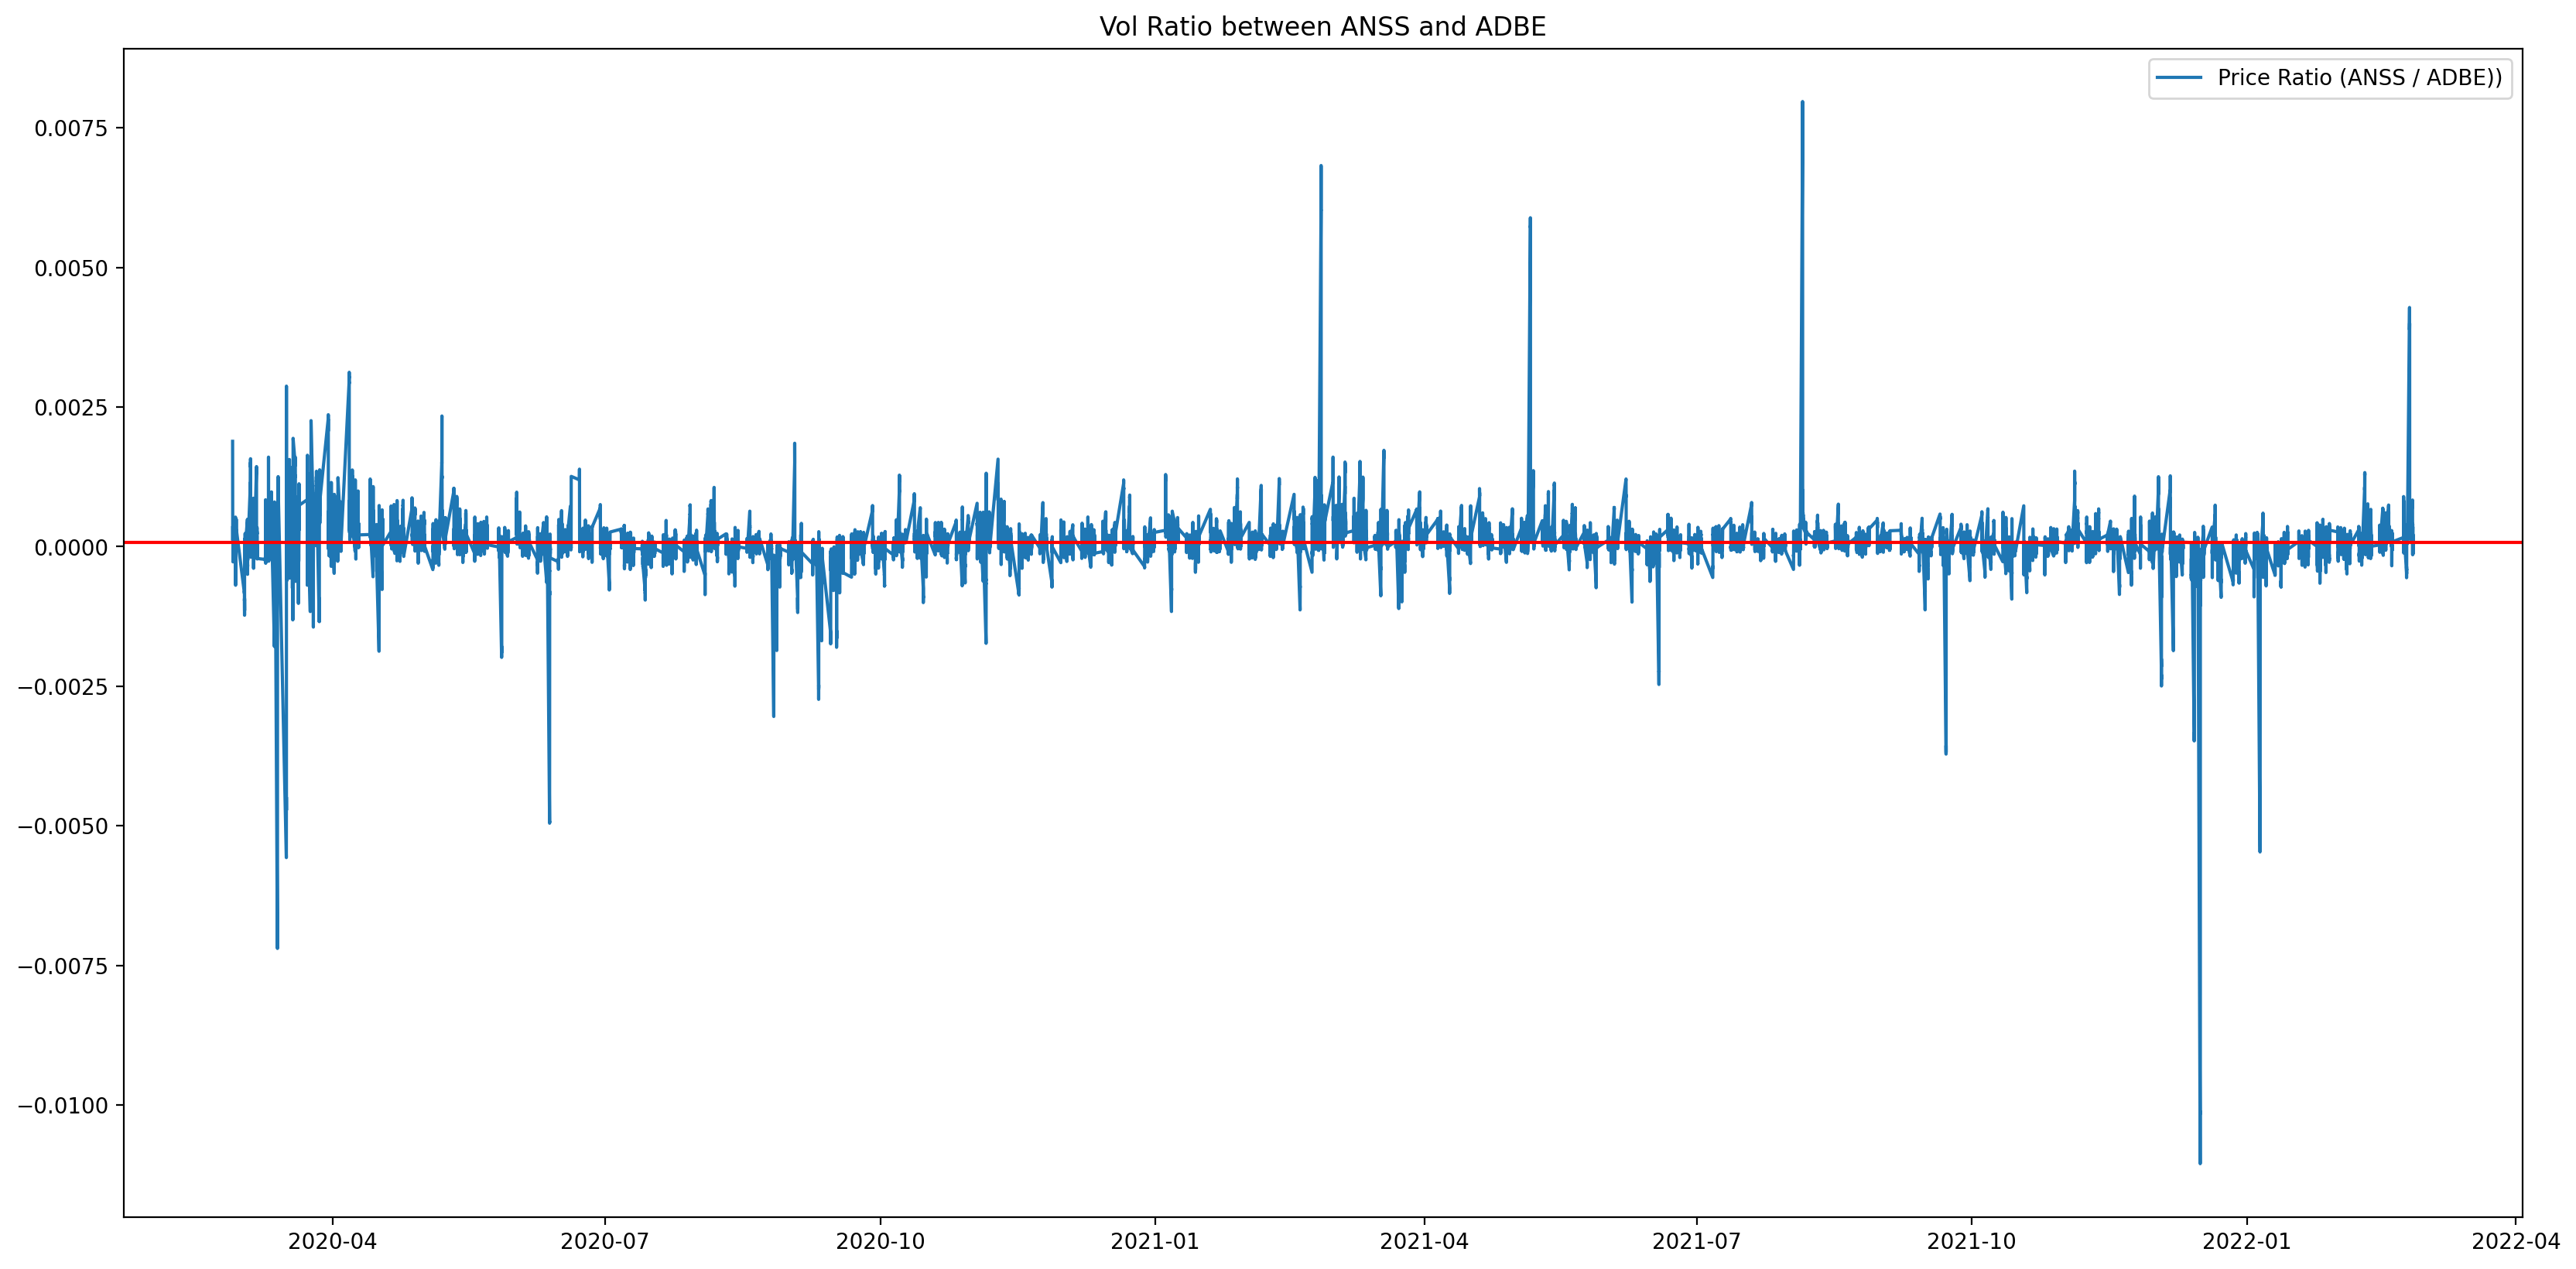

In [105]:
# Also, we can take a look at the price ratios between the two time series.
figure(figsize=(20, 10), dpi=200)
ratio = ANSS - ADBE
plt.plot(ratio, label = 'Price Ratio (ANSS / ADBE))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Vol Ratio between ANSS and ADBE")

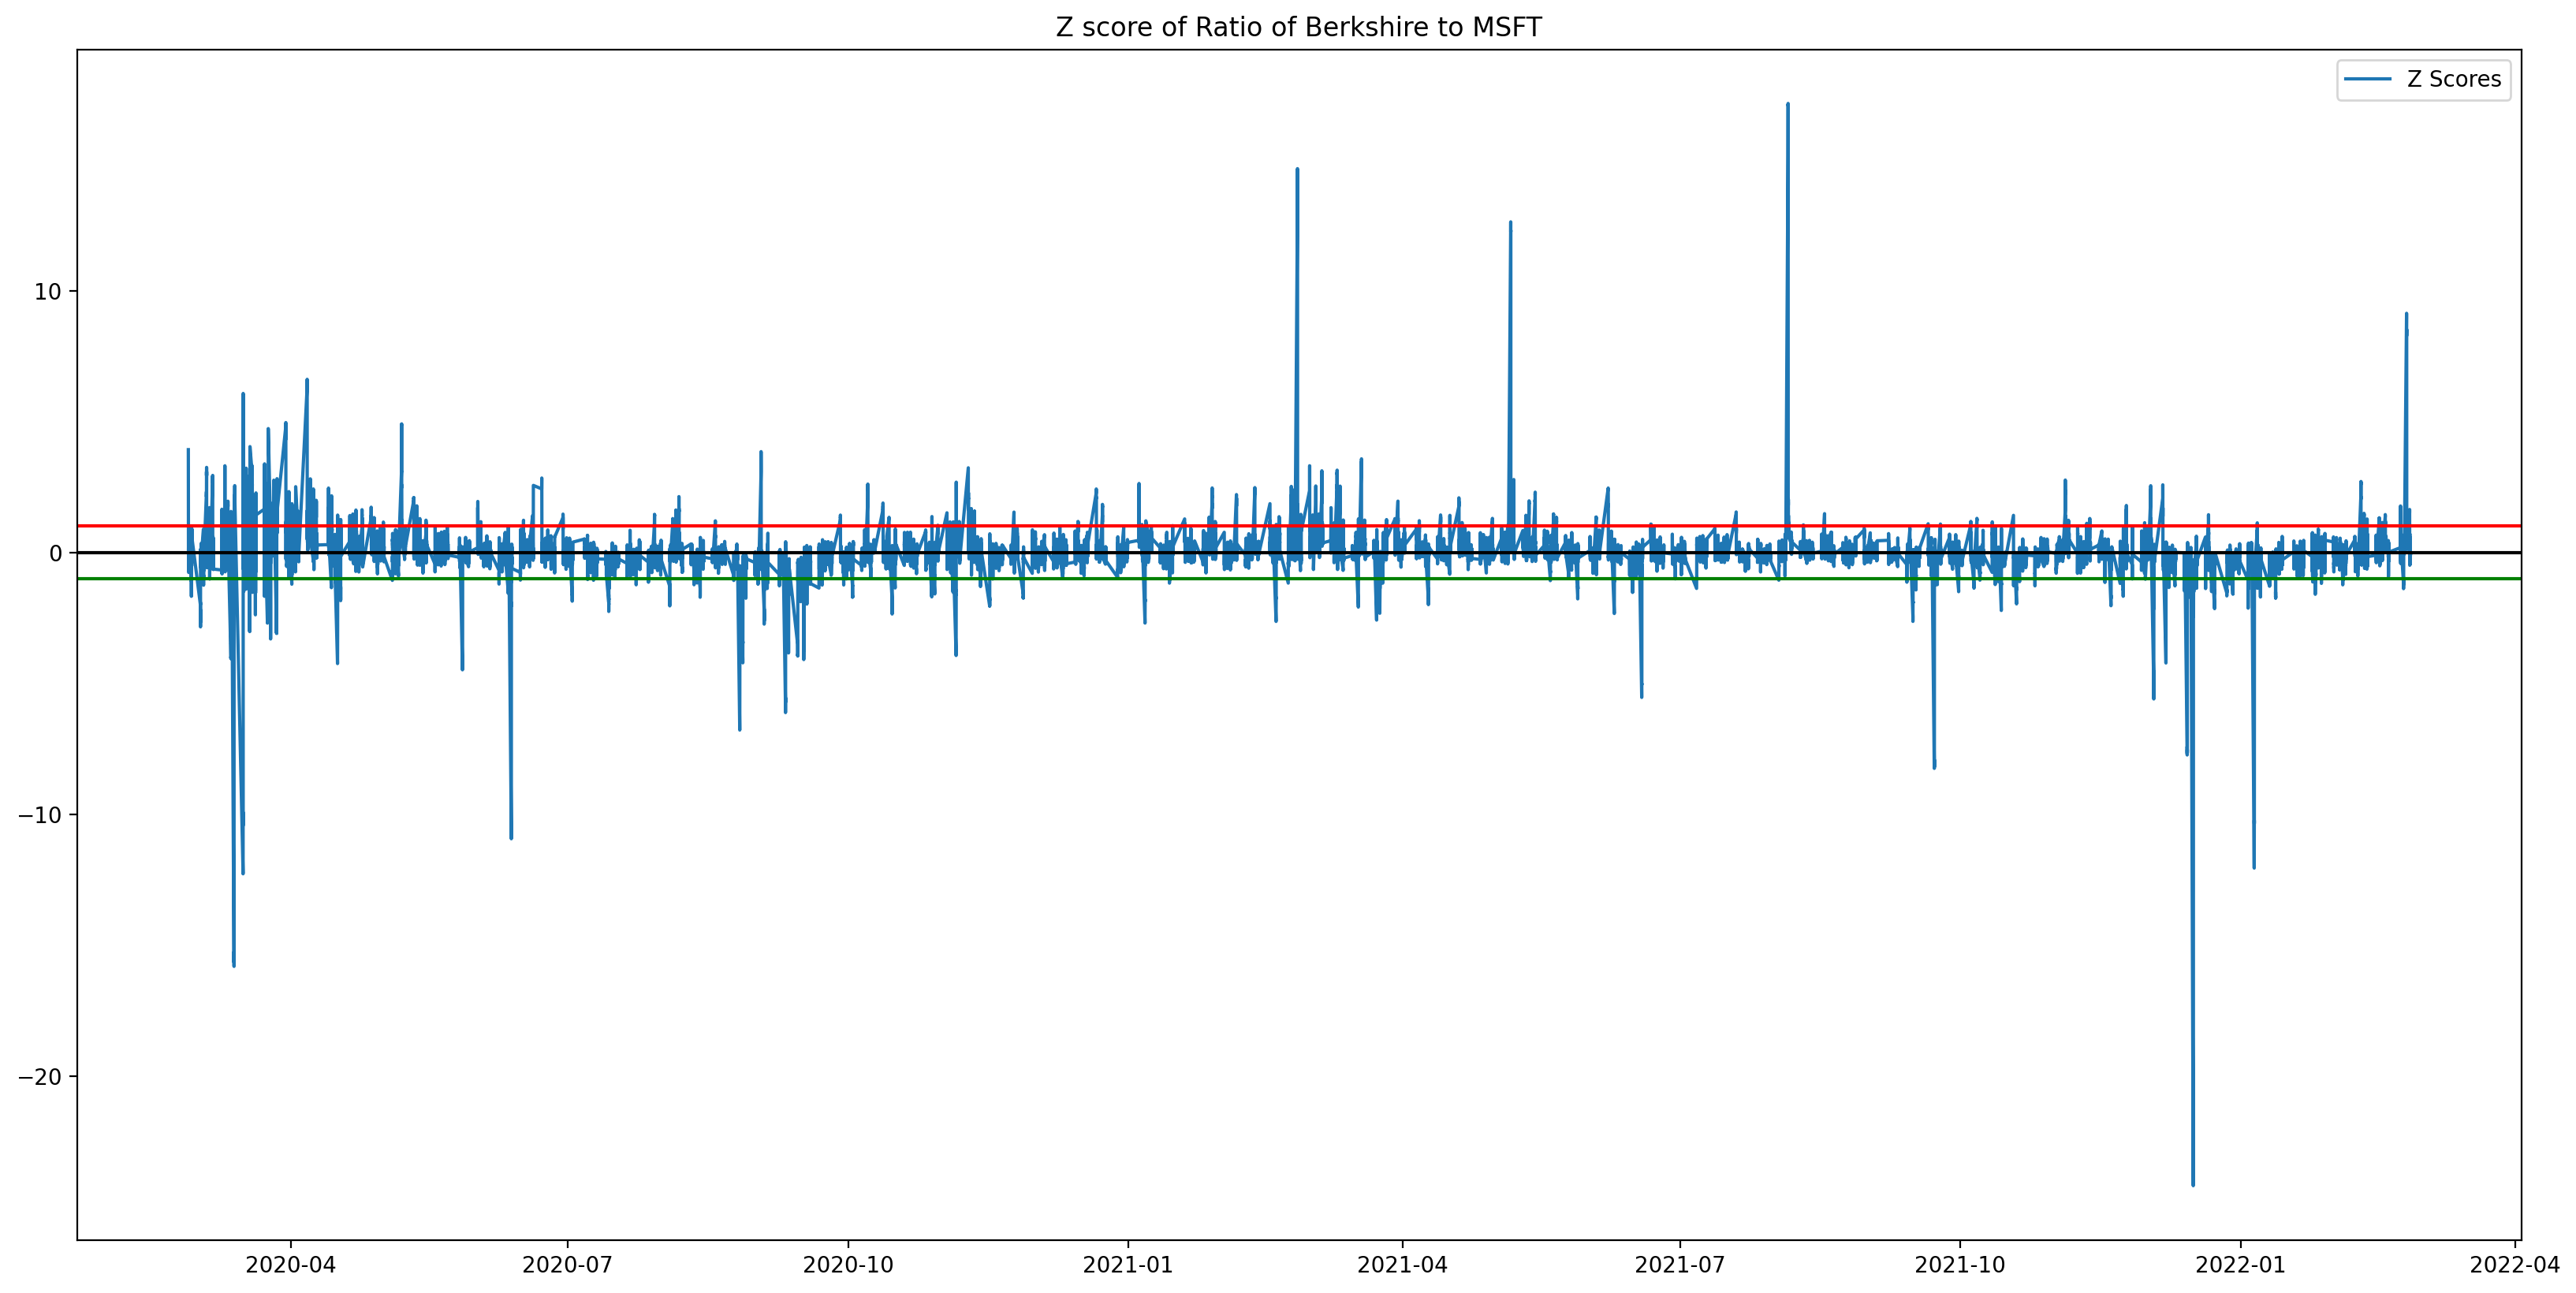

In [106]:
# NOTE, here I can either use the spread OR the Price ratio approach. Anyways, let's standardize the ratio so we can have a 
# upper and lower bound to help evaluate our trends.. Let's stick with the ratio data.
figure(figsize=(20, 10), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
#plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1, color='red') # 95% of our data will lie between these bounds.
#plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of Berkshire to MSFT')


## Q5期权市场运作模式，ask bid价格差距比较大，意味着成本高，怎么选择合适的strike price，call/put，buy/sell?

In [111]:
# Test for Black Scholes method 
def bsm(S,K,T,r,q,sigma,call=True):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    if call==True:
        return S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-q*T)*norm.cdf(-d1)

expiration_datex = datetime(2022,5,14)
now = datetime(2022,3,1)
S = 165
K = 178
T = (expiration_date-now).days/365
r = 0.25/100
q = 0.53/100
sigma = 0.3
call_prices = bsm(S,K,T,r,q,sigma,call=True)
put_prices = bsm(S,K,T,r,q,sigma,call=False) 
print(call_prices)

4.118987541946446